In [ ]:
import numpy as np
from PIL import Image
import functools

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.figsize'] = (10,10)
mpl.rcParams['axes.grid'] = False

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import vgg19
from tensorflow.keras.preprocessing import image as kp_image
from tensorflow.keras.initializers import RandomNormal

from copy import copy

In [ ]:
SQUARE_DIM = 256
DEPTH = 3
IMG_FILE = "test2014/"

# Import style and test content images

In [ ]:
import os

img_dir = '/content/nst_images'
if not os.path.exists(img_dir):
    os.makedirs(img_dir)

!wget --quiet -P /content/nst_images https://upload.wikimedia.org/wikipedia/commons/d/d7/Green_Sea_Turtle_grazing_seagrass.jpg -O /content/nst_images/Turtle.jpg
!wget --quiet -P /content/nst_images https://upload.wikimedia.org/wikipedia/commons/0/0a/The_Great_Wave_off_Kanagawa.jpg -O /content/nst_images/Wave.jpg
!wget --quiet -P /content/nst_images https://upload.wikimedia.org/wikipedia/commons/b/b4/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg -O /content/nst_images/Kandinsky.jpg
!wget --quiet -P /content/nst_images https://upload.wikimedia.org/wikipedia/commons/0/00/Tuebingen_Neckarfront.jpg -O /content/nst_images/Tubingen.jpg
!wget --quiet -P /content/nst_images https://upload.wikimedia.org/wikipedia/commons/6/68/Pillars_of_creation_2014_HST_WFC3-UVIS_full-res_denoised.jpg -O /content/nst_images/Pillars.jpg
!wget --quiet -P /content/nst_images https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg/1024px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg -O /content/nst_images/VanGogh.jpg

# Download Training Images from Microsoft COCO Dataset

In [ ]:
!wget --no-check-certificate https://images.cocodataset.org/zips/test2014.zip

--2020-12-07 09:05:59--  https://images.cocodataset.org/zips/test2014.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.14.140
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.14.140|:443... connected.
	requested host name ‘images.cocodataset.org’.
HTTP request sent, awaiting response... 200 OK
Length: 6660437059 (6.2G) [application/zip]
Saving to: ‘test2014.zip’

test2014.zip        100%[===================>]   6.20G  13.4MB/s    in 7m 47s  

2020-12-07 09:13:47 (13.6 MB/s) - ‘test2014.zip’ saved [6660437059/6660437059]



In [ ]:
!unzip test2014.zip

# Define Image transformation model

In [ ]:
#weight_init = tf.initializers.GlorotUniform()

class ConvLayer(tf.keras.layers.Layer):
    
    def __init__(self, out_channels, kernel_size, stride):
        super(ConvLayer, self).__init__()
        #reflection_padding = kernel_size // 2
        #self.reflection_pad = ReflectionPadding2D(reflection_padding)
        self.conv2d = tf.keras.layers.Conv2D(out_channels, (kernel_size, kernel_size), strides = stride, padding = 'same')#, kernel_initializer = weight_init)
        
    def call(self, x):
        #x = self.reflection_pad(x)
        x = self.conv2d(x)
        return x
        
'''class ReflectionPadding2D(tf.keras.layers.Layer):
    def __init__(self, padding):
        super(ReflectionPadding2D, self).__init__()
        self.padding = (padding, padding)

    def call(self, x, mask=None):
        w_pad,h_pad = self.padding
        return tf.pad(x, [[0,0], [h_pad,h_pad], [w_pad,w_pad], [0,0]], 'REFLECT')  '''

In [ ]:
class ResidualLayer(tf.keras.layers.Layer):
    
    def __init__(self, channels):
        super(ResidualLayer, self).__init__()
        self.conv1 = ConvLayer(channels, kernel_size = 3, stride = 1)
        self.batch1 = tf.keras.layers.BatchNormalization()
        self.conv2 = ConvLayer(channels, kernel_size = 3, stride = 1)
        self.batch2 = tf.keras.layers.BatchNormalization()
        self.activation_relu = tf.keras.layers.Activation('relu')
        self.add_op = tf.keras.layers.Add()
        
    def call(self, x_input, training = True):
        
        # The shortcut path
        x_res = x_input
        
        # The convolution block
        x = self.conv1(x_input)
        x = self.batch1(x)
        x = self.activation_relu(x)
        x = self.conv2(x)
        x = self.batch2(x)
        
        # Add the shortcut path to complete the residual block
        x = self.add_op([x, x_res])
        x = self.activation_relu(x)
        return x

In [ ]:
class UpsampleConvLayer(tf.keras.layers.Layer):
    """UpsampleConvLayer
    Upsamples the input and then does a convolution. This method gives better results
    compared to ConvTranspose2d.
    ref: http://distill.pub/2016/deconv-checkerboard/
    """

    def __init__(self, channels, kernel_size, stride, upsample_factor):
        super(UpsampleConvLayer, self).__init__()
        self.upsample_factor = upsample_factor
        self.conv2d = ConvLayer(channels, kernel_size, stride)
        #s#elf.channels = channels
        #s#elf.conv2d = tf.keras.layers.Conv2D(channels, kernel_size = (3,3), activation='relu', padding = 'same', strides = stride),

    def call(self, x):
        b, w, h, c = np.shape(x)
        x = tf.image.resize(x, [w*self.upsample_factor, h*self.upsample_factor])
        x = self.conv2d(x)
        #x = tf.keras.layers.Conv2D(self.channels, kernel_size = (3,3), activation='relu', padding = 'same', strides = 1)(x)
        return x

In [ ]:
class ResNet(tf.keras.Model):
    
    def __init__(self):
        super(ResNet, self).__init__()
        
        # Convolutional Layers
        self.conv1 = ConvLayer(32, kernel_size = 9, stride = 1)
        self.conv2 = ConvLayer(64, kernel_size = 3, stride = 2)
        self.conv3 = ConvLayer(128, kernel_size = 3, stride = 2)
        
        # Residual Layers
        self.res1 = ResidualLayer(128)
        self.res2 = ResidualLayer(128)
        self.res3 = ResidualLayer(128)
        self.res4 = ResidualLayer(128)
        self.res5 = ResidualLayer(128)
        
        # Upsampling Layers
        self.deconv1 = UpsampleConvLayer(64, kernel_size = 3, stride = 1, upsample_factor = 2)
        self.deconv2 = UpsampleConvLayer(32, kernel_size = 3, stride = 1, upsample_factor = 2)
        self.deconv3 = ConvLayer(3, kernel_size = 9, stride = 1)
        
        self.relu = tf.keras.layers.Activation('relu')
        self.batch1 = tf.keras.layers.BatchNormalization()
        self.batch2 = tf.keras.layers.BatchNormalization()
        self.batch3 = tf.keras.layers.BatchNormalization()
        self.batch4 = tf.keras.layers.BatchNormalization()
        self.batch5 = tf.keras.layers.BatchNormalization()
        
    def call(self, x_input, training = True):
        
        # Convolution Block

        x = self.relu(self.batch1(self.conv1(x_input)))
        x = self.relu(self.batch2(self.conv2(x)))
        x = self.relu(self.batch3(self.conv3(x)))
        
        # Residual Block
        x = self.res1(x, training = training)
        x = self.res2(x, training = training)
        x = self.res3(x, training = training)
        x = self.res4(x, training = training)
        x = self.res5(x, training = training)

        # Deconvolution Block
        x = self.relu(self.batch4(self.deconv1(x)))
        x = self.relu(self.batch5(self.deconv2(x)))
        x = self.deconv3(x)
        return x

# Image loading and processing

In [ ]:
def load_and_process_style_image(style_path, process = True):

    max_dim = 512
    img = Image.open(style_path)
    long = max(img.size)
    scale = max_dim/long
    img = img.resize((round(img.size[0]*scale), round(img.size[1]*scale)), Image.ANTIALIAS)

    img = kp_image.img_to_array(img)

    # We need to broadcast the image array such that it has a batch dimension 
    img = np.expand_dims(img, axis=0)

    if process:
        img = tf.keras.applications.vgg19.preprocess_input(img)
    return img

In [ ]:
def load_and_process_content_image(path, process = True, isTFvariable = True):

    """
    Function to load an image.
    Resizes to 256*256
    If image is to be pre-processed for the VGG19 network, performs preprocessing.
    Converts image from a PIL.Image to a numpy array.
    Adds the batch dimension necessary for the image to be processed by the network

    Inputs:
    path: string with path to the image
    process: Bool
    max_dim: The desired maximum dimension, by default set to 512

    Returns: Resized, pre-processed image of dimensions (batch = 1, new_height, new_width, channels = 3)
    """
    
    img = Image.open(path)
    width, height = img.size
    
    # if landscape
    if width > height:
        scale = SQUARE_DIM/height
        new_width = round(width * scale)
        img = img.resize((new_width, SQUARE_DIM))
        img = img.crop(((new_width - SQUARE_DIM)//2, 0, (new_width - SQUARE_DIM)//2 + SQUARE_DIM, 256))

        # if portrait
    else:
        scale = SQUARE_DIM/width
        new_height = round(height * scale)
        img = img.resize((SQUARE_DIM, new_height))
        img = img.crop((0, (new_height - SQUARE_DIM)//2, 256, (new_height - SQUARE_DIM)//2 + SQUARE_DIM))

        img = kp_image.img_to_array(img) 
        img = np.expand_dims(img, axis=0)

    if process:
        img = tf.keras.applications.vgg19.preprocess_input(img)

    if isTFvariable:
        return tf.Variable(img, dtype = tf.float32)
    else:
        return img

In [ ]:
def show_image(img):

    # Remove the batch dimension
    if len(img.shape) == 4:
        img = np.squeeze(img, axis = 0) 
        
    if len(img.shape) != 3:
        raise ValueError("Invalid input shape")

    # Convert from array of floats to array of ints
    plt.imshow(img.astype('uint8'))
    
    return

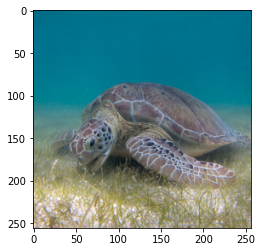

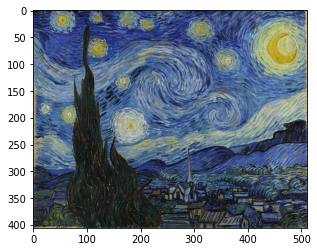

In [ ]:
content_path = "/content/nst_images/Turtle.jpg"
style_path = "/content/nst_images/VanGogh.jpg"

content_img = load_and_process_content_image(content_path, process = False, isTFvariable=False)
style_img = load_and_process_style_image(style_path, process = False)

show_image(content_img)
plt.show()
show_image(style_img)
plt.show()

In [ ]:
def load_and_process_image_batches(path_batch, toProcess = True, toNormalise = False):

    """
    Function to resize a batch of training images and ensure that they are all default size
    Rotates portrait images to landscape orientation before resizing
    Pre-processes each image

    Inputs:
    path_batch: List of paths to training images
    new_width, new_height: Set by default to (256, 256)

    Returns: 4D numpy array, with shape (Batch-size, 256, 256, 3)
    """
    
    img_batch = []

    for path in path_batch:

        img = Image.open(IMG_FILE + path)
        width, height = img.size
    
      # if landscape
        if width > height:
            scale = SQUARE_DIM/height
            new_width = round(width * scale)
            img = img.resize((new_width, SQUARE_DIM))
            img = img.crop(((new_width - SQUARE_DIM)//2, 0, (new_width - SQUARE_DIM)//2 + SQUARE_DIM, 256))

            # if portrait
        else:
            scale = SQUARE_DIM/width
            new_height = round(height * scale)
            img = img.resize((SQUARE_DIM, new_height))
            img = img.crop((0, (new_height - SQUARE_DIM)//2, 256, (new_height - SQUARE_DIM)//2 + SQUARE_DIM))
      
        img = kp_image.img_to_array(img) 

        if np.shape(img)[-1] != DEPTH:
            continue
      
        img_batch.append(img)
        img_stack = np.stack(img_batch)

    if toProcess:
        img_stack = tf.keras.applications.vgg19.preprocess_input(img_stack)

    return tf.Variable(img_stack, dtype = tf.float32)

In [ ]:
def deprocess_image(processed_img):

    x = processed_img.copy()
    if len(x.shape) == 4:
        x = np.squeeze(x, axis = 0)
        
    assert len(x.shape) == 3, ("Input to deprocess image must be an image of" 
                                "dimension [1, height, width, channel] or [height, width, channel]")
    if len(x.shape) != 3:
        raise ValueError("Invalid input to deprocessing image")
    
    # perform the inverse of the preprocessing step
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68

    x = x[:, :, ::-1] # Convert from BGR to RGB
    x = np.clip(x, 0, 255).astype('uint8')
    return x

## Load the Loss Model, define style and content feature representations and define the loss function

In [ ]:
# Content layer where will pull our feature maps
content_layers = ['block4_conv2'] 

# Style layer we are interested in
style_layers = ['block1_conv1', 'block2_conv1','block3_conv1', 'block4_conv1', 'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

def get_model():

    # Load pretrained VGG model, trained on image-net data
    vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights ='imagenet')
    vgg.trainable = False
    
    # Get output layers corresponding to style and content layers 
    style_outputs = [vgg.get_layer(name).output for name in style_layers]
    content_outputs = [vgg.get_layer(name).output for name in content_layers]
    model_outputs = style_outputs + content_outputs
    
    return tf.keras.models.Model(vgg.input, model_outputs)

In [ ]:
def compute_content_loss(input_content_img, target):
    # Compute euclidean distance between input image and target
    return tf.math.reduce_sum(tf.math.square(target - input_content_img))

def compute_gram_matrix(input_tensor):
    channels = int(input_tensor.shape[-1])
    # using -1 in reshape infers the correct shape
    a = tf.reshape(input_tensor, [-1, channels])
    n = tf.shape(a)[0]
    gram = tf.matmul(a, a, transpose_a=True)
    return gram / tf.cast(n, tf.float32)

def compute_style_loss(style_feature, gram_target):
    height, width, channels = style_feature.shape
    gram_style_feature = compute_gram_matrix(style_feature)
    return tf.math.reduce_mean(tf.square(gram_style_feature - gram_target))

In [ ]:
def get_style_feature_representations(model, style_path):
 
    # batch compute content and style features
    style_img = load_and_process_style_image(style_path)
    style_outputs = model(style_img)
    
    # Get the style and content feature representations from our model  
    style_features = [style_layer[0] for style_layer in style_outputs[:num_style_layers]]
    return style_features

def get_content_feature_representations(model, content_img):
  
    # Compute content outputs
    content_outputs = model(content_img)

    # Get content feature representations from the model
    content_features = [content_layer[0] for content_layer in content_outputs[num_style_layers:]]

    return content_features

In [ ]:
def compute_total_loss(loss_model, loss_weights, input_batch, gram_target_style_features, target_content_features):

    style_weight, content_weight = loss_weights

    y_hat = MODEL(input_batch)

    assert np.shape(input_batch) == np.shape(y_hat)

    # This will give us the content and style representations at our desired layers.
    y_hat_loss_model_outputs = loss_model(y_hat)
    y_hat_style_features = [style_layer[0] for style_layer in y_hat_loss_model_outputs[:num_style_layers]]
    y_hat_content_features = [content_layer[0] for content_layer in y_hat_loss_model_outputs[num_style_layers:]]
  
    style_score = 0
    content_score = 0

    weight_per_style_layer = [0.2, 0.2, 0.2, 0.2, 0.2]
    
    for y_hat_style_feature, gram_target_style_feature, weight in zip(y_hat_style_features, gram_target_style_features, weight_per_style_layer):
        style_score += weight * compute_style_loss(y_hat_style_feature, gram_target_style_feature)
                                      
    for y_hat_content_feature, target_content_feature in zip(y_hat_content_features, target_content_features):
        content_score += compute_content_loss(y_hat_content_feature, target_content_feature)
    
    style_score *= style_weight
    content_score *= content_weight

    total_score = style_score + content_score
    return total_score, style_score, content_score

In [ ]:
def step(cfg):
    with tf.GradientTape() as tape:
        total_loss, style_loss, content_loss = compute_total_loss(**cfg)
    grads = tape.gradient(total_loss, MODEL.trainable_variables)
    return grads, total_loss, style_loss, content_loss

In [ ]:
def run_NST(style_path, start, end, batch_size, content_weight, style_weight):#, pre_trained_model = None):
  
    train_images = os.listdir("test2014/")[start * batch_size : end * batch_size]

    '''if pre_trained_model == None:
    res_model = ResNet()
    else:
    res_model = pre_trained_model'''

    vgg_model = get_model()

    style_features = get_style_feature_representations(vgg_model, style_path)
    gram_style_features = [compute_gram_matrix(style_feature) for style_feature in style_features]

    test_img = load_and_process_content_image("/content/nst_images/Turtle.jpg")

    '''test_img = np.random.randn(1, 256, 256, 3)*255
    test_img = tf.keras.applications.vgg19.preprocess_input(test_img)
    test_img = tf.Variable(test_img, dtype = tf.float32)'''

    total_loss_history = []
    content_loss_history = []
    style_loss_history = []

    optimiser = tf.keras.optimizers.Adam(learning_rate = 1e-4, beta_1 = 0.9, epsilon = 1e-1)

    for i in range(len(train_images)//batch_size):

    batch = train_images[i * batch_size : (i+1) * batch_size]

    img_batch = load_and_process_image_batches(batch)
    content_features = get_content_feature_representations(vgg_model, img_batch)

    #img_batch = test_img

    cfg = {
        #'transformer_model': res_model,
        'loss_model': vgg_model,
        'loss_weights': (style_weight, content_weight),
        'input_batch': img_batch,
        'gram_target_style_features': gram_style_features,
        'target_content_features': content_features,
    }

    grads, total_loss, style_loss, content_loss = step(cfg)
    optimiser.apply_gradients(zip(grads, MODEL.trainable_variables))

    if i % 100 == 0:
        print('Batch: {}'.format(i))        
        print('Total loss: {:.4e}, ' 
            'style loss: {:.4e}, '
            'content loss: {:.4e}'.format(total_loss, style_loss, content_loss))

        transformed_test = MODEL(test_img)
        show_image(deprocess_image(transformed_test.numpy()))
        plt.show()

    total_loss_history.append(total_loss)
    style_loss_history.append(style_loss)
    content_loss_history.append(content_loss)

    return total_loss_history, style_loss_history, content_loss_history

In [ ]:
MODEL = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(32, (9, 9), activation='relu', padding = 'same', input_shape=(256, 256, 3), strides = 1),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding = 'same', strides = 2),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding = 'same', strides = 2),
  tf.keras.layers.BatchNormalization(),
  ResidualLayer(128),
  ResidualLayer(128),
  ResidualLayer(128),
  ResidualLayer(128),
  ResidualLayer(128),
  UpsampleConvLayer(64, kernel_size = 3, stride = 1, upsample_factor = 2),
  tf.keras.layers.BatchNormalization(),
  UpsampleConvLayer(32, kernel_size = 3, stride = 1, upsample_factor = 2),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Conv2D(3, kernel_size = 9, strides = 1, padding = 'same')
])

In [ ]:
MODEL.compile()
MODEL.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_223 (Conv2D)          (None, 256, 256, 32)      7808      
_________________________________________________________________
batch_normalization_210 (Bat (None, 256, 256, 32)      128       
_________________________________________________________________
conv2d_224 (Conv2D)          (None, 128, 128, 64)      18496     
_________________________________________________________________
batch_normalization_211 (Bat (None, 128, 128, 64)      256       
_________________________________________________________________
conv2d_225 (Conv2D)          (None, 64, 64, 128)       73856     
_________________________________________________________________
batch_normalization_212 (Bat (None, 64, 64, 128)       512       
_________________________________________________________________
residual_layer_70 (ResidualL (None, 64, 64, 128)     

Batch: 0
Total loss: 5.4132e+15, style loss: 5.3662e+15, content loss: 4.6970e+13


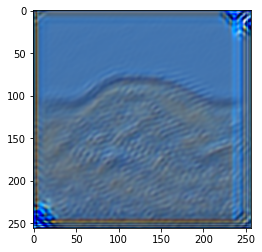

Batch: 100
Total loss: 5.2328e+15, style loss: 5.1858e+15, content loss: 4.6994e+13


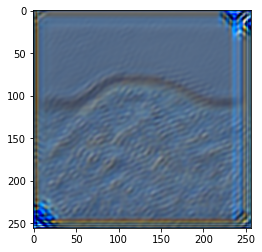

Batch: 200
Total loss: 6.6063e+15, style loss: 6.5474e+15, content loss: 5.8828e+13


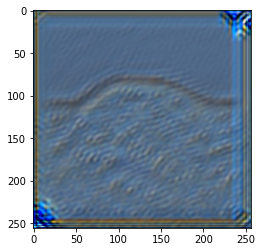

Batch: 300
Total loss: 4.9293e+15, style loss: 4.8733e+15, content loss: 5.5958e+13


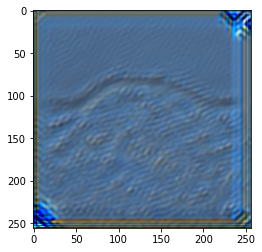

Batch: 400
Total loss: 4.9893e+15, style loss: 4.9574e+15, content loss: 3.1917e+13


In [ ]:
total_loss, style_loss, content_loss = run_NST(style_path, 1000, 4000, 4, 1e2, 1e6)

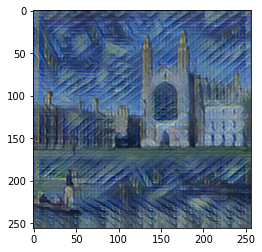

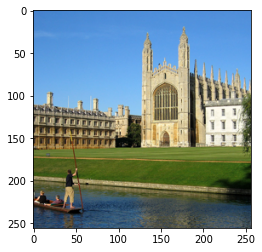

In [ ]:
demo_img = load_and_process_content_image("/content/nst_images/Cambridge.jpg")
output = trained_model(demo_img)
show_image(deprocess_image(output.numpy()))
plt.show()
show_image(deprocess_image(demo_img.numpy()))
plt.show()